In [ ]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# Agregar la carpeta 'src' al sys.path
import sys
import os
src_path = os.path.abspath("../src")
if src_path not in sys.path:
    sys.path.append(src_path)
    import support_RandomForestRegressor as sp

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/df_te.csv")
df.sample(5)

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,fuelType,brand,notRepairedDamage,powerCV_robust,kilometer_robust
280991,5722.744529,5722.69042,4500.0,5721.515220,5845.597432,5236.859483,9965.928441,8454.021359,8037.616582,6707.871077,0.898551,0.0
55859,5722.744529,5722.69042,2400.0,5721.515220,2912.480757,5236.859483,4654.329823,4702.257069,3807.880938,6707.871077,-0.594203,-1.0
193729,5722.744529,5722.69042,11850.0,5723.869135,9217.484988,11654.559866,4654.329823,4702.257069,2998.934386,6707.871077,-0.652174,-5.8
316953,5722.744529,5722.69042,1000.0,5721.515220,9342.620539,1769.244434,4654.329823,4702.257069,8229.975718,2369.921733,1.217391,0.0
196930,5722.744529,5722.69042,1000.0,5723.869135,5212.719911,1769.244434,4654.329823,4702.257069,3073.553291,6707.871077,-0.594203,0.0


In [3]:
x=df.drop("price",axis=1)
y=df[["price"]]
x_train, x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42)

In [4]:
# Grid de Hiperparámetros
param_dist_rf = {
    'n_estimators': [100, 150],
    'max_depth': [15, 20, 25],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
}

random_search_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
# Entrenamiento
random_search_rf.fit(x_train, y_train)

# Mejor modelo
best_rf = random_search_rf.best_estimator_
print(f"Mejores parámetros: {random_search_rf.best_params_}")

Mejores parámetros: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}


In [5]:
y_test_pred_rf = best_rf.predict(x_test)
y_train_pred_rf = best_rf.predict(x_train)
sp.metricas(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

,r2_score,MAE,MSE,RMSE
Train,0.8874,1303.0111,5.085728e+06,2255.1559
Test,0.8394,1501.2234,7.145609e+06,2673.1272
Diferenceias,0.0480,-198.2123,-2.059881e+06,-417.9713
Porcentaje diferencia (%),5.7184,-15.2119,-4.050320e+01,-18.5340
Media,5719.2157,5719.2157,5.719216e+03,5719.2157
Influencia media (%),0.0008,3.4657,3.601684e+04,7.3082
Mediana,3200.0000,3200.0000,3.200000e+03,3200.0000
Influencia mediana (%),0.0015,6.1941,6.437127e+04,13.0616


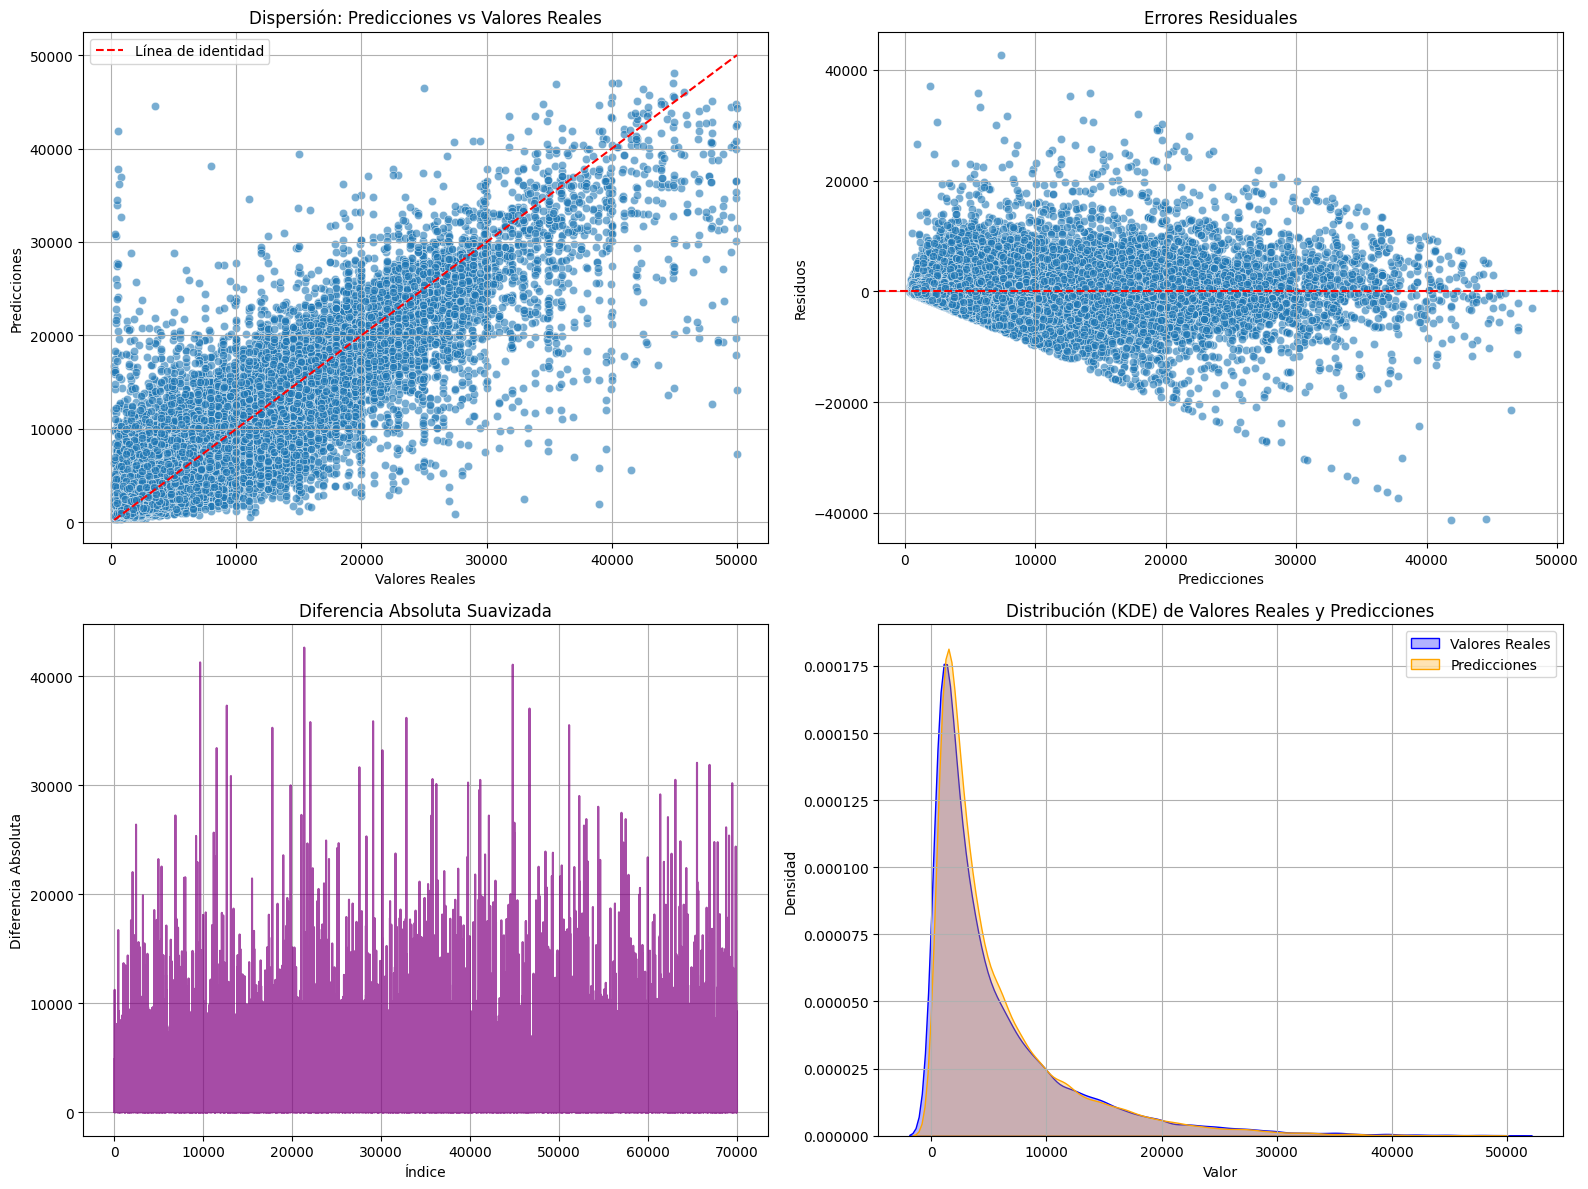

In [6]:
sp.comparativa_graficos(y_test, y_test_pred_rf)

### PROBAMOS A MEJORAR EL MODELO ELIMINANDO VARIABLES CON POCA REPERCUSIÓN

Calculamos la correlación de las variables con "price" para ver cuales pueden ser eliminadas por no ser representativas en el modelo

Correlaciones con 'price':
price                 1.000000
powerCV_robust        0.558097
yearOfRegistration    0.495365
brand                 0.377761
vehicleType           0.340023
gearbox               0.330771
fuelType              0.275689
notRepairedDamage     0.245723
offerType             0.001745
seller                0.000614
abtest                0.000175
kilometer_robust     -0.444155
Name: price, dtype: float64


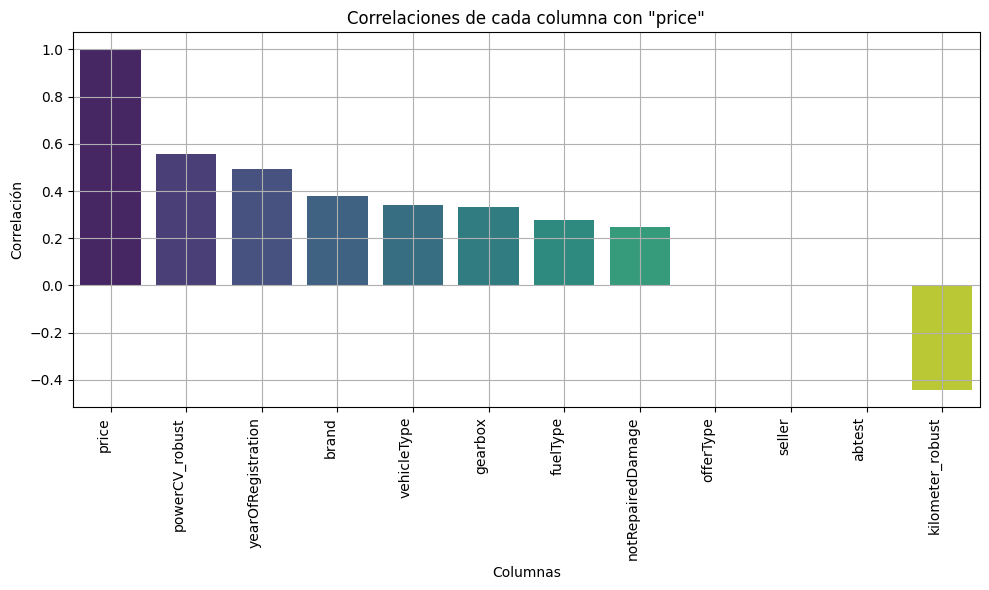


Columnas con baja correlación (abs < 0.05):
['offerType', 'seller', 'abtest']


['offerType', 'seller', 'abtest']

In [7]:
sp.analizar_correlaciones(df, "price", threshold=0.05)

In [8]:
# Excluir columnas irrelevantes según el análisis previo
columns_to_exclude = ['seller', 'offerType', 'abtest']
df_filtered = df.drop(columns=columns_to_exclude)

In [9]:
# Definir las características (X) y la variable objetivo (y)
x2 = df_filtered.drop(columns=['price'])
y2 = df_filtered['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)

In [10]:
# Grid de Hiperparámetros
param_dist_rf = {
    'n_estimators': [100, 150],
    'max_depth': [15, 20, 25],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
}

random_search_rf2 = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
# Entrenamiento
random_search_rf2.fit(x_train2, y_train2)

# Mejor modelo
best_rf2 = random_search_rf2.best_estimator_
print(f"Mejores parámetros: {random_search_rf2.best_params_}")

Mejores parámetros: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}


In [11]:
y_test_pred_rf2 = best_rf2.predict(x_test2)
y_train_pred_rf2 = best_rf2.predict(x_train2)
sp.metricas(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

,r2_score,MAE,MSE,RMSE
Train,0.8847,1316.7758,5.209506e+06,2282.4343
Test,0.8411,1491.4299,7.070861e+06,2659.1090
Diferenceias,0.0436,-174.6541,-1.861355e+06,-376.6747
Porcentaje diferencia (%),5.1837,-13.2638,-3.573000e+01,-16.5032
Media,5719.2157,5719.2157,5.719216e+03,5719.2157
Influencia media (%),0.0008,3.0538,3.254563e+04,6.5861
Mediana,3200.0000,3200.0000,3.200000e+03,3200.0000
Influencia mediana (%),0.0014,5.4579,5.816733e+04,11.7711


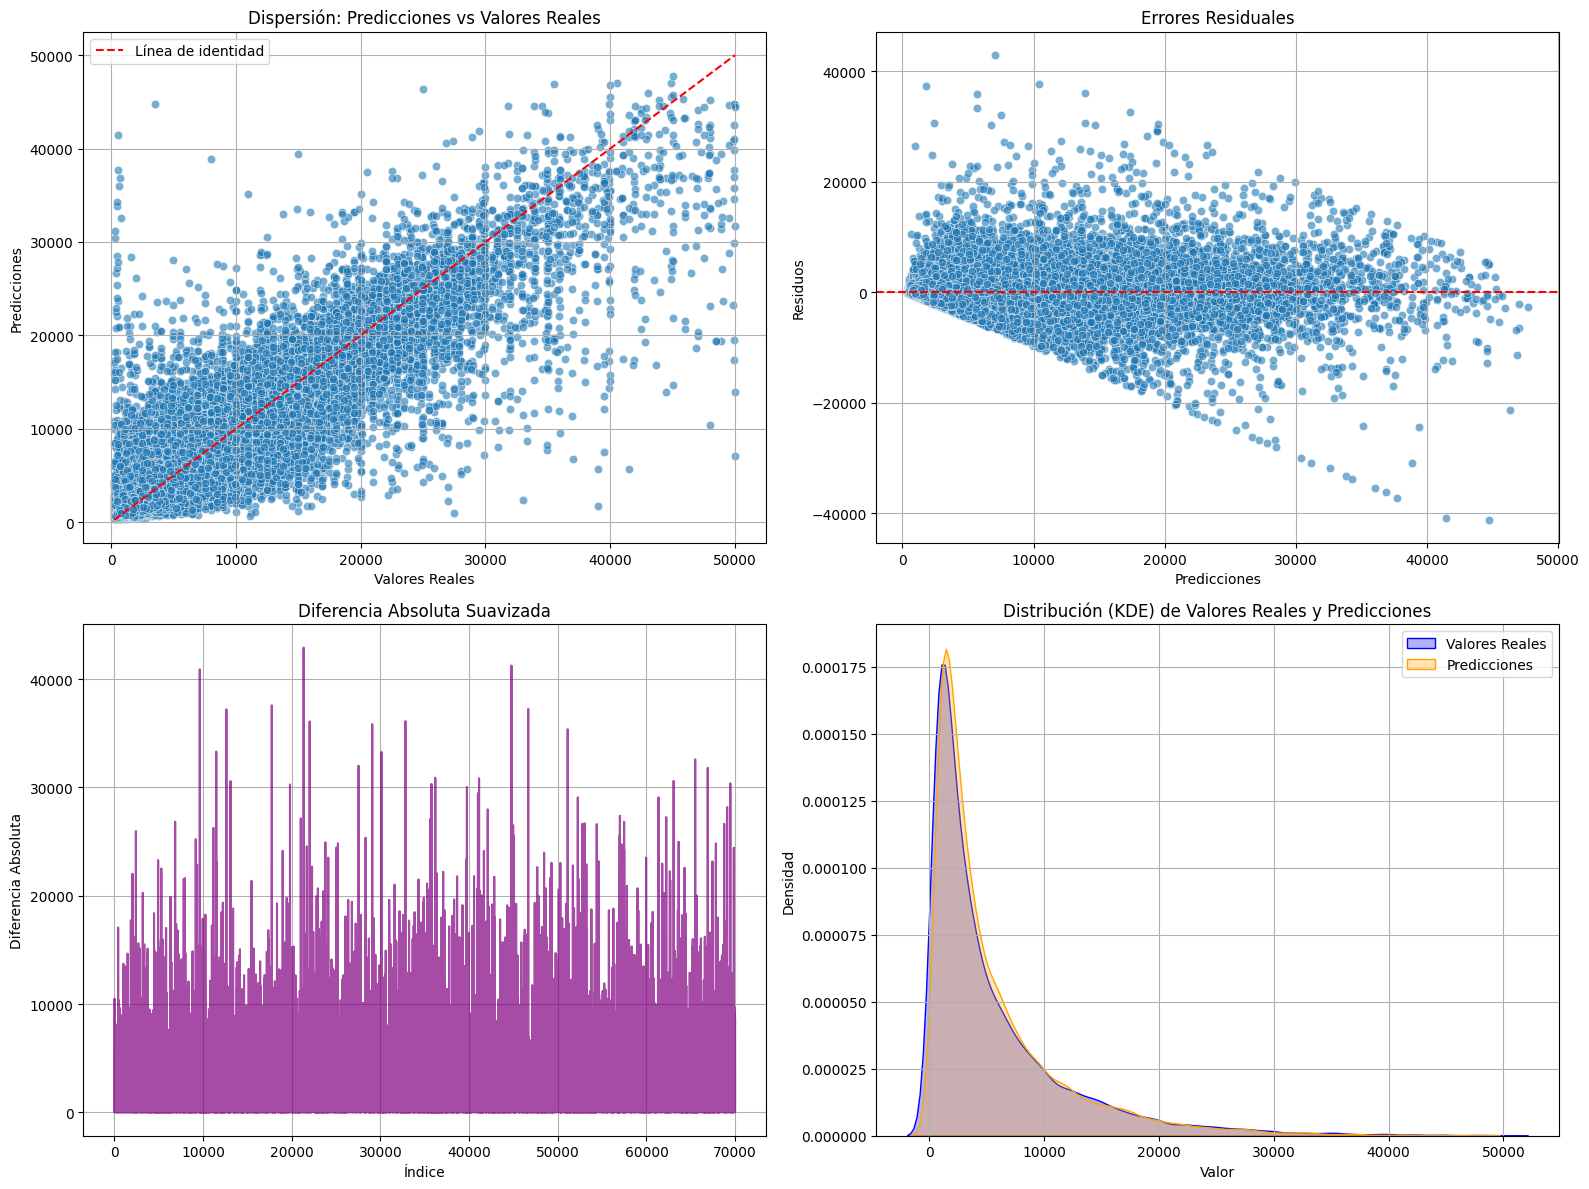

In [12]:
sp.comparativa_graficos( y_test2, y_test_pred_rf2)

#### Ahora vamos a tratar de mejorar el modelo por última vez eliminando precios muy extremos que podemos calificar como outiers que generan ruido en el modelo

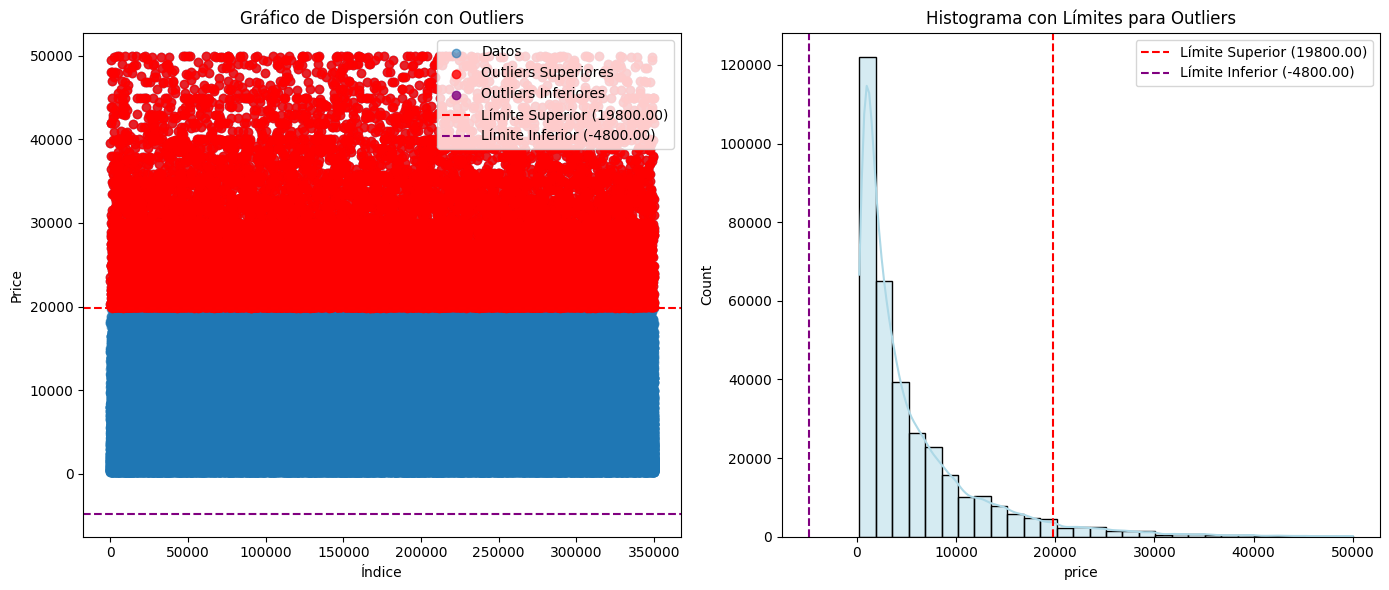

Valores considerados outliers superiores:


,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,fuelType,brand,notRepairedDamage,powerCV_robust,kilometer_robust
53,5722.744529,5722.69042,39600.0,5723.869135,9342.620539,11654.559866,9965.928441,4702.257069,8229.975718,6707.871077,2.739130,-4.8
75,5722.744529,5722.69042,20300.0,5723.869135,5212.719911,11654.559866,9965.928441,8454.021359,8037.616582,6707.871077,1.275362,-2.8
91,5722.744529,5722.69042,23490.0,5721.515220,5212.719911,11654.559866,9965.928441,8454.021359,8229.975718,6707.871077,0.405797,-4.4
97,5722.744529,5722.69042,22999.0,5721.515220,9342.620539,11654.559866,9965.928441,4702.257069,5567.866573,6707.871077,0.434783,-2.8
139,5722.744529,5722.69042,41900.0,5721.515220,12585.761184,11654.559866,9965.928441,8454.021359,8037.616582,6707.871077,1.275362,-4.4
...,...,...,...,...,...,...,...,...,...,...,...,...
349873,5722.744529,5722.69042,21499.0,5721.515220,5212.719911,11654.559866,9965.928441,8454.021359,8229.975718,6707.871077,1.275362,0.0
349914,5722.744529,5722.69042,23900.0,5721.515220,5845.597432,11654.559866,9965.928441,8454.021359,8229.975718,6707.871077,1.275362,0.0
349920,5722.744529,5722.69042,20500.0,5721.515220,5212.719911,11654.559866,9965.928441,8454.021359,8037.616582,6707.871077,0.304348,-3.6
349936,5722.744529,5722.69042,20400.0,5723.869135,5212.719911,11654.559866,9965.928441,4702.257069,5407.374502,6707.871077,0.507246,-4.8



Valores considerados outliers inferiores:


,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,fuelType,brand,notRepairedDamage,powerCV_robust,kilometer_robust



Umbral superior para considerar outliers: 19800.00
Umbral inferior para considerar outliers: -4800.00


In [ ]:
# Cálculo del rango intercuartílico (IQR)
q1 = df['price'].quantile(0.25)  # Primer cuartil
q3 = df['price'].quantile(0.75)  # Tercer cuartil
iqr = q3 - q1

# Definir límites para identificar outliers (tanto superiores como inferiores)
lower_bound = q1 - 1 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrar los outliers superiores e inferiores
outliers_superiores = df[df['price'] > upper_bound]
outliers_inferiores = df[df['price'] < lower_bound]

# Visualizar los resultados
plt.figure(figsize=(14, 6))

# Gráfico de dispersión mostrando los valores y los outliers
plt.subplot(1, 2, 1)
plt.scatter(range(len(df)), df['price'], alpha=0.6, label='Datos')
plt.scatter(outliers_superiores.index, outliers_superiores['price'], color='red', label='Outliers Superiores', alpha=0.8)
plt.scatter(outliers_inferiores.index, outliers_inferiores['price'], color='purple', label='Outliers Inferiores', alpha=0.8)
plt.axhline(upper_bound, color='red', linestyle='--', label=f'Límite Superior ({upper_bound:.2f})')
plt.axhline(lower_bound, color='purple', linestyle='--', label=f'Límite Inferior ({lower_bound:.2f})')
plt.title('Gráfico de Dispersión con Outliers')
plt.xlabel('Índice')
plt.ylabel('Price')
plt.legend()

# Histograma resaltando los outliers
plt.subplot(1, 2, 2)
sns.histplot(df['price'], bins=30, kde=True, color='lightblue')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'Límite Superior ({upper_bound:.2f})')
plt.axvline(lower_bound, color='purple', linestyle='--', label=f'Límite Inferior ({lower_bound:.2f})')
plt.title('Histograma con Límites para Outliers')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar información sobre los outliers
print("Valores considerados outliers superiores:")
display(outliers_superiores)

print("\nValores considerados outliers inferiores:")
display(outliers_inferiores)

print(f"\nUmbral superior para considerar outliers: {upper_bound:.2f}")
print(f"Umbral inferior para considerar outliers: {lower_bound:.2f}")

In [20]:
# Ver valores atipicos de "price"
limite_inferior = 300
limite_superior = upper_bound

df_filtered_copy=df_filtered.copy()

# Filtro los valores fuera de rango
valores_fuera_rango = df_filtered_copy[(df_filtered_copy['price'] < limite_inferior) | (df_filtered_copy['price'] > limite_superior)]

# Reemplazo los valores fuera de rango por NaN
df_filtered_copy.loc[df_filtered_copy['price'] < limite_inferior, 'price'] = np.nan
df_filtered_copy.loc[df_filtered_copy['price'] > limite_superior, 'price'] = np.nan

# Elimino las filas con NaN en la columna 'price' en el DataFrame original
df_filtered2 = df_filtered_copy.dropna(subset=['price'])

# Ver la forma del DataFrame con valores fuera de rango
valores_fuera_rango.shape

(20054, 9)

In [21]:
# Definir las características (X) y la variable objetivo (y)
x3 = df_filtered2.drop(columns=['price'])
y3 = df_filtered2['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, random_state=42)

In [22]:
# Grid de Hiperparámetros
param_dist_rf = {
    'n_estimators': [100, 150],
    'max_depth': [15, 20, 25],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
}

random_search_rf3 = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10,  # Número de combinaciones a probar
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Entrenamiento
random_search_rf3.fit(x_train3, y_train3)

# Mejor modelo
best_rf3 = random_search_rf3.best_estimator_
print(f"Mejores parámetros: {random_search_rf3.best_params_}")

Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 25}


In [23]:
y_test_pred_rf3 = best_rf3.predict(x_test3)
y_train_pred_rf3 = best_rf3.predict(x_train3)
sp.metricas(y_train3, y_train_pred_rf3, y_test3, y_test_pred_rf3)

,r2_score,MAE,MSE,RMSE
Train,0.8526,1108.1787,2.890546e+06,1700.1607
Test,0.8111,1239.5231,3.660692e+06,1913.2935
Diferenceias,0.0415,-131.3444,-7.701457e+05,-213.1328
Porcentaje diferencia (%),5.1165,-11.8523,-2.664360e+01,-12.5360
Media,4658.3994,4658.3994,4.658399e+03,4658.3994
Influencia media (%),0.0009,2.8195,1.653241e+04,4.5752
Mediana,2999.0000,2999.0000,2.999000e+03,2999.0000
Influencia mediana (%),0.0014,4.3796,2.568008e+04,7.1068


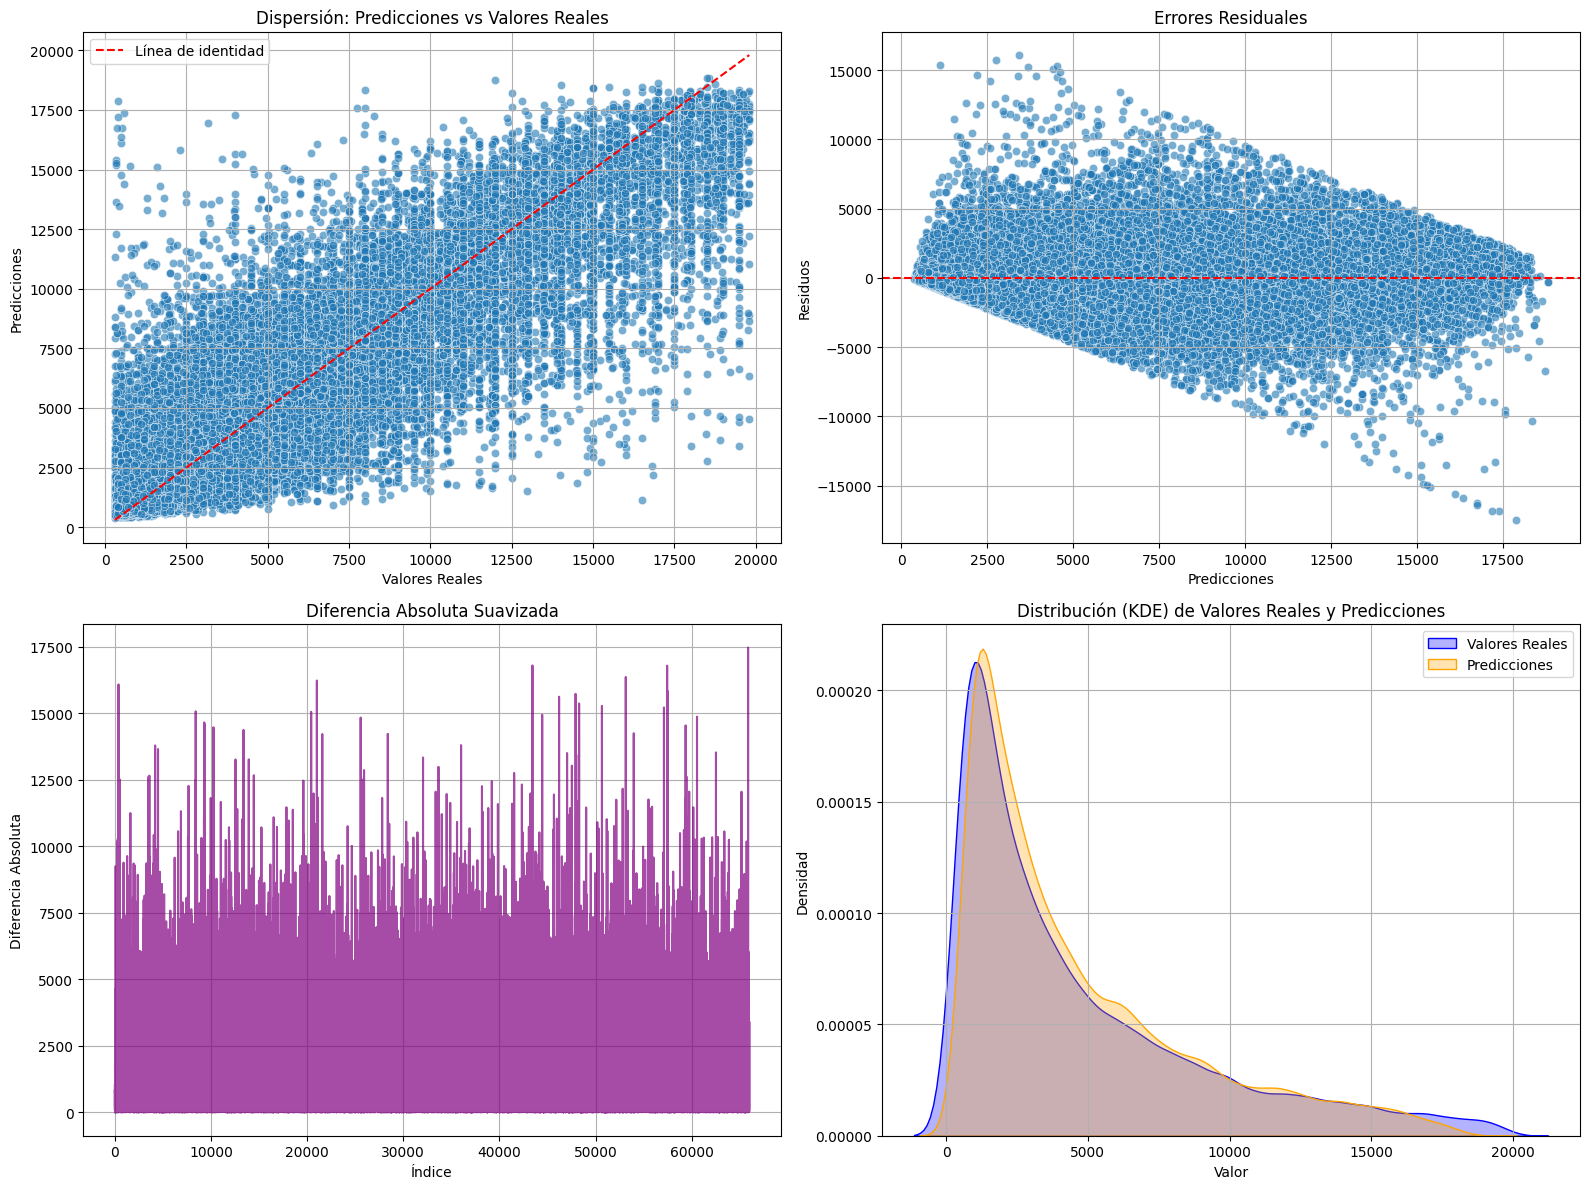

In [24]:
sp.comparativa_graficos( y_test3, y_test_pred_rf3)

#### COMPARATIVA DE METRICAS

In [25]:
sp.metricas(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

,r2_score,MAE,MSE,RMSE
Train,0.8874,1303.0111,5.085728e+06,2255.1559
Test,0.8394,1501.2234,7.145609e+06,2673.1272
Diferenceias,0.0480,-198.2123,-2.059881e+06,-417.9713
Porcentaje diferencia (%),5.7184,-15.2119,-4.050320e+01,-18.5340
Media,5719.2157,5719.2157,5.719216e+03,5719.2157
Influencia media (%),0.0008,3.4657,3.601684e+04,7.3082
Mediana,3200.0000,3200.0000,3.200000e+03,3200.0000
Influencia mediana (%),0.0015,6.1941,6.437127e+04,13.0616


In [26]:
sp.metricas(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

,r2_score,MAE,MSE,RMSE
Train,0.8847,1316.7758,5.209506e+06,2282.4343
Test,0.8411,1491.4299,7.070861e+06,2659.1090
Diferenceias,0.0436,-174.6541,-1.861355e+06,-376.6747
Porcentaje diferencia (%),5.1837,-13.2638,-3.573000e+01,-16.5032
Media,5719.2157,5719.2157,5.719216e+03,5719.2157
Influencia media (%),0.0008,3.0538,3.254563e+04,6.5861
Mediana,3200.0000,3200.0000,3.200000e+03,3200.0000
Influencia mediana (%),0.0014,5.4579,5.816733e+04,11.7711


In [27]:
sp.metricas(y_train3, y_train_pred_rf3, y_test3, y_test_pred_rf3)

,r2_score,MAE,MSE,RMSE
Train,0.8526,1108.1787,2.890546e+06,1700.1607
Test,0.8111,1239.5231,3.660692e+06,1913.2935
Diferenceias,0.0415,-131.3444,-7.701457e+05,-213.1328
Porcentaje diferencia (%),5.1165,-11.8523,-2.664360e+01,-12.5360
Media,4658.3994,4658.3994,4.658399e+03,4658.3994
Influencia media (%),0.0009,2.8195,1.653241e+04,4.5752
Mediana,2999.0000,2999.0000,2.999000e+03,2999.0000
Influencia mediana (%),0.0014,4.3796,2.568008e+04,7.1068
